[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-5/memory_store.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/59970887-lesson-1-short-vs-long-term-memory)

다음은 요청하신 내용의 자연스러운 한국어 번역입니다.

# 메모리를 가진 챗봇

## 개요

[기억(Memory)](https://pmc.ncbi.nlm.nih.gov/articles/PMC10410470/)은 사람들이 정보를 저장, 검색, 사용하여 현재와 미래를 이해할 수 있도록 하는 인지 기능입니다.

AI 애플리케이션에서 사용할 수 있는 [다양한 유형의 장기 기억](https://langchain-ai.github.io/langgraph/concepts/memory/#memory)이 있습니다.

## 목표

여기서는 장기 기억을 저장하고 검색하는 방법으로 [LangGraph 메모리 스토어](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)를 소개합니다.

단기(`short-term (within-thread)`) 메모리와 장기(`long-term (across-thread)`) 메모리를 모두 사용하는 챗봇을 만들어 보겠습니다.

저희는 사용자에 대한 사실들인 장기 [의미 기억(semantic memory)](https://langchain-ai.github.io/langgraph/concepts/memory/#semantic-memory)에 중점을 둘 것입니다.

이러한 장기 기억은 사용자에 대한 사실을 기억하여 개인화된 경험을 제공하는 챗봇을 만드는 데 사용됩니다.

챗봇은 사용자와 대화하는 중에 실시간으로["in the hot path"](https://langchain-ai.github.io/langgraph/concepts/memory/#writing-memories) 메모리를 저장하게 됩니다.

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai

다음으로, 환경 변수를 설정합니다.

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## LangGraph 스토어 소개

[LangGraph 메모리 스토어](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)는 LangGraph에서 *스레드 간에* 정보를 저장하고 검색하는 방법을 제공합니다.

이것은 영구적인 `키-값(key-value)` 스토어를 위한 [오픈 소스 기본 클래스](https://www.google.com/search?q=https.blog.langchain.dev/launching-long-term-memory-support-in-langgraph/)입니다.

In [4]:
import uuid
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()

[스토어(Store)](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)에 객체(예: 메모리)를 저장할 때는 다음 정보를 제공합니다.

  - 객체의 `namespace`: (디렉터리와 유사한) 튜플
  - 객체의 `key`: (파일 이름과 유사)
  - 객체의 `value`: (파일 내용과 유사)

`namespace`와 `key`를 지정하여 [put](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.put) 메서드로 스토어에 객체를 저장합니다.

![](https://i.imgur.com/KxnS7lY.png)


In [5]:
# 저장할 메모리를 위한 네임스페이스
user_id = "1"
namespace_for_memory = (user_id, "memories")

# 메모리를 키와 값으로 네임스페이스에 저장
key = str(uuid.uuid4())

# 값은 사전이어야 합니다
value = {"food_preference": "나는 피자를 좋아한다"}

# 기억을 간직하라
in_memory_store.put(namespace_for_memory, key, value)

`namespace`를 기준으로 스토어에서 객체를 검색할 때는 [search](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.search)를 사용합니다.

결과값으로 리스트가 반환됩니다.

In [6]:
# Search
memories = in_memory_store.search(namespace_for_memory)
type(memories)

list

In [7]:
# Metatdata
memories[0].dict()

{'namespace': ['1', 'memories'],
 'key': '6e480dcc-8cee-4a74-a1f9-23a9a7df93d1',
 'value': {'food_preference': '나는 피자를 좋아한다'},
 'created_at': '2025-10-02T07:51:15.888884+00:00',
 'updated_at': '2025-10-02T07:51:15.888886+00:00',
 'score': None}

In [8]:
# The key, value
print(memories[0].key, memories[0].value)

6e480dcc-8cee-4a74-a1f9-23a9a7df93d1 {'food_preference': '나는 피자를 좋아한다'}


또한 [get](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore.get)을 사용하여 `namespace`와 `key`로 객체를 검색할 수도 있습니다.

In [9]:
# 네임스페이스와 키로 메모리를 가져오기
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

{'namespace': ['1', 'memories'],
 'key': '6e480dcc-8cee-4a74-a1f9-23a9a7df93d1',
 'value': {'food_preference': '나는 피자를 좋아한다'},
 'created_at': '2025-10-02T07:51:15.888884+00:00',
 'updated_at': '2025-10-02T07:51:15.888886+00:00'}

## 장기 기억(long-term)을 가진 챗봇

여기서 만들고자 하는 챗봇은 다음과 같이 [두 가지 유형의 메모리](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_156)를 가집니다.

1. `단기 (스레드 내) 메모리`: 챗봇이 대화 기록을 유지하여, 하나의 채팅 세션이 중단되더라도 대화를 이어갈 수 있습니다.
2. `장기 (스레드 간) 메모리`: 챗봇이 *모든 채팅 세션에 걸쳐* 특정 사용자에 대한 정보를 기억합니다.

In [10]:
_set_env("OPENAI_API_KEY")

`단기 메모리`를 위해서는 [체크포인터(checkpointer)](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries)를 사용할 것입니다.

체크포인터에 대한 더 자세한 내용은 모듈 2와 저희의 [개념 문서](https://langchain-ai.github.io/langgraph/concepts/persistence/)를 참조하세요. 간단히 요약하면 다음과 같습니다.

* 각 단계의 그래프 상태를 스레드에 기록합니다.
* 스레드에 대화 기록을 유지합니다.
* 스레드의 어느 단계에서든 그래프가 중단되거나 재개될 수 있도록 합니다.

그리고 `장기 메모리`를 위해서는 위에서 소개한 [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)를 사용할 것입니다.

In [11]:
from langchain_openai import ChatOpenAI

# LLM 초기화
model = ChatOpenAI(model="gpt-4o", temperature=0)

대화 기록은 체크포인터를 사용하여 단기 메모리에 저장됩니다.

챗봇은 이 대화 기록을 성찰합니다.

그런 다음 메모리를 생성하여 [LangGraph Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore)에 저장합니다.

이 메모리는 향후 채팅 세션에서 챗봇의 응답을 개인화하는 데 사용될 수 있습니다.

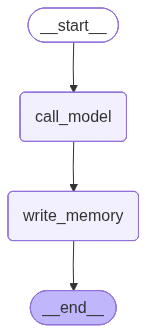

In [12]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# 챗봇 지시사항
MODEL_SYSTEM_MESSAGE = """당신은 사용자에 대한 정보를 제공하는, 
기억력을 가진 유용한 어시스턴트입니다.
이 사용자에 대한 메모리가 있다면, 응답을 개인화하는 데 사용하세요.
메모리는 다음과 같습니다 (비어 있을 수 있습니다): {memory}"""

# 대화 기록과 기존 메모리를 바탕으로 새로운 메모리 생성
CREATE_MEMORY_INSTRUCTION = """
당신은 응답을 개인화하기 위해 사용자에 대한 정보를 수집하고 있습니다.

## 현재 사용자 정보:
{memory}

## 지시사항:
1. 아래의 대화 기록을 주의 깊게 검토하세요
2. 다음과 같은 사용자에 대한 새로운 정보를 식별하세요:
   - 개인 정보 (이름, 위치)
   - 선호도 (좋아하는 것, 싫어하는 것)
   - 관심사 및 취미
   - 과거 경험
   - 목표 또는 미래 계획
3. 새로운 정보가 있다면 기존 메모리와 병합하세요
4. 메모리를 명확한 글머리 기호 목록 형식으로 만드세요
5. 새로운 정보가 기존 메모리와 충돌하는 경우, 가장 최신 버전을 유지하세요

## 주의: 
- 사용자가 직접 언급한 사실 정보만 포함하세요. 
- 추측이나 추론을 하지 마세요.

아래 대화 기록을 바탕으로 사용자 정보를 업데이트해주세요:"""


def call_model(
    state: MessagesState,
    config: RunnableConfig,
    store: BaseStore,
):
    """스토어에서 메모리를 불러와 챗봇의 응답을 개인화합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 스토어에서 메모리 검색
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # 메모리가 존재하면 실제 메모리 내용을 추출합니다.
    if existing_memory:
        # 값(Value)은 'memory' 키를 가진 딕셔너리입니다.
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "기존 메모리가 없습니다."

    # 시스템 프롬프트에 메모리 형식 지정
    system_msg = MODEL_SYSTEM_MESSAGE.format(
        memory=existing_memory_content,
    )

    # 메모리와 대화 기록을 함께 사용하여 응답
    response = model.invoke(
        [SystemMessage(content=system_msg)] + state["messages"],
    )

    return {"messages": [response]}


def write_memory(
    state: MessagesState,
    config: RunnableConfig,
    store: BaseStore,
):
    """대화 기록을 성찰하고 스토어에 메모리를 저장합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 스토어에서 기존 메모리 검색
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # 메모리 추출
    if existing_memory:
        existing_memory_content = existing_memory.value.get("memory")
    else:
        existing_memory_content = "기존 메모리가 없습니다."

    # 시스템 프롬프트에 메모리 형식 지정
    system_msg = CREATE_MEMORY_INSTRUCTION.format(
        memory=existing_memory_content,
    )
    new_memory = model.invoke(
        [SystemMessage(content=system_msg)] + state["messages"],
    )

    # 스토어의 기존 메모리 덮어쓰기
    key = "user_memory"

    # 값을 'memory' 키를 가진 딕셔너리로 작성
    store.put(namespace, key, {"memory": new_memory.content})

    # 아무것도 반환하지 않음
    return


# 그래프 정의
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.set_entry_point("call_model")
builder.add_edge("call_model", "write_memory")
builder.set_finish_point("write_memory")

# 장기 (스레드 간) 메모리를 위한 스토어
across_thread_memory = InMemoryStore()

# 단기 (스레드 내) 메모리를 위한 체크포인터
within_thread_memory = MemorySaver()

# 체크포인터와 스토어를 연결하여 그래프를 컴파일합니다.
graph = builder.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory,
)

# 그래프 시각화
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

챗봇과 상호작용할 때는 다음 두 가지를 제공합니다.

1. `단기 (스레드 내) 메모리`: 대화 기록을 유지하기 위한 `스레드 ID`.
2. `장기 (스레드 간) 메모리`: 장기 메모리를 사용자별로 관리하기 위한 `사용자 ID`.

이것들이 실제로 어떻게 함께 작동하는지 살펴보겠습니다.

In [13]:
# 단기 (스레드 내) 메모리를 위해 스레드 ID를 제공합니다.
# 장기 (스레드 간) 메모리를 위해 사용자 ID를 제공합니다.
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 사용자 입력
input_messages = [
    HumanMessage(content="안녕하세요, 제 이름은 랜스입니다."),
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요, 제 이름은 랜스입니다.
================================== Ai Message ==================================

안녕하세요, 랜스님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?


In [14]:
# 사용자 입력
input_messages = [
    HumanMessage(content="저는 샌프란시스코를 자전거로 돌아다니는 걸 좋아합니다."),
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

저는 샌프란시스코를 자전거로 돌아다니는 걸 좋아합니다.
================================== Ai Message ==================================

샌프란시스코는 자전거 타기에 정말 멋진 도시죠! 금문교를 자전거로 건너보셨나요? 아니면 다른 추천할 만한 경로가 있으신가요?


스레드 내 메모리를 위해 `MemorySaver` 체크포인터를 사용하고 있습니다.

이것은 대화 기록을 스레드에 저장합니다.

스레드에 저장된 대화 기록을 살펴볼 수 있습니다.

In [15]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

안녕하세요, 제 이름은 랜스입니다.
================================== Ai Message ==================================

안녕하세요, 랜스님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?
================================ Human Message =================================

저는 샌프란시스코를 자전거로 돌아다니는 걸 좋아합니다.
================================== Ai Message ==================================

샌프란시스코는 자전거 타기에 정말 멋진 도시죠! 금문교를 자전거로 건너보셨나요? 아니면 다른 추천할 만한 경로가 있으신가요?


그래프를 컴파일할 때 스토어를 사용했다는 것을 기억해 보세요.

```python
across_thread_memory = InMemoryStore()
```

그리고 대화 기록을 성찰하여 메모리를 스토어에 저장하는 `write_memory` 노드를 그래프에 추가했습니다.

이제 메모리가 스토어에 저장되었는지 확인할 수 있습니다.

In [16]:
# 저장할 메모리를 위한 네임스페이스
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

{'namespace': ['memory', '1'],
 'key': 'user_memory',
 'value': {'memory': '- 개인 정보:\n  - 이름: 랜스\n  - 위치: 샌프란시스코\n\n- 선호도:\n  - 좋아하는 것: 샌프란시스코를 자전거로 돌아다니는 것\n\n- 관심사 및 취미:\n  - 자전거 타기'},
 'created_at': '2025-10-02T07:51:21.441092+00:00',
 'updated_at': '2025-10-02T07:51:21.441093+00:00'}

이제 *동일한 사용자 ID*로 *새로운 스레드*를 시작하겠습니다.

챗봇이 사용자의 프로필을 기억하고 응답을 개인화하는 것을 확인할 수 있을 것입니다.

In [17]:
# 스레드 간 메모리를 위한 사용자 ID와 새로운 스레드 ID를 제공합니다.
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# 사용자 입력
input_messages = [
    HumanMessage(content="안녕하세요! 자전거 타러 어디 가면 좋을까요?"),
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 자전거 타러 어디 가면 좋을까요?
================================== Ai Message ==================================

안녕하세요, 랜스! 샌프란시스코에서 자전거 타기에 좋은 곳을 추천드릴게요. 

1. **골든 게이트 파크**: 넓고 다양한 경로가 있어서 자전거 타기에 아주 좋습니다. 자연을 즐기며 여유롭게 탈 수 있어요.

2. **마린 헤드랜즈**: 골든 게이트 브리지를 건너면 나오는 이 지역은 멋진 경치와 함께 도전적인 코스를 제공합니다.

3. **엠바카데로**: 해안가를 따라 자전거를 타며 도시의 활기찬 분위기를 느낄 수 있습니다.

4. **프레시디오**: 역사적인 장소와 아름다운 자연 경관을 함께 즐길 수 있는 곳입니다.

이 중에서 마음에 드는 곳이 있나요?


In [18]:
# 사용자 입력
input_messages = [
    HumanMessage(
        content="좋아요, 근처에 들러볼 만한 빵집 있나요? 자전거 타고 나면 크루아상이 먹고 싶거든요."
    )
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

좋아요, 근처에 들러볼 만한 빵집 있나요? 자전거 타고 나면 크루아상이 먹고 싶거든요.
================================== Ai Message ==================================

자전거 타고 나서 크루아상을 즐기기에 좋은 빵집 몇 곳을 추천드릴게요!

1. **타르틴 베이커리 (Tartine Bakery)**: 미션 디스트릭트에 위치한 이곳은 샌프란시스코에서 가장 유명한 빵집 중 하나로, 크루아상이 아주 맛있습니다.

2. **비 파티세리 (b. Patisserie)**: 퍼시픽 하이츠에 위치한 이곳은 프랑스 스타일의 페이스트리로 유명하며, 크루아상이 특히 인기가 많습니다.

3. **아르스티산 베이커리 (Arsicault Bakery)**: 리치먼드 디스트릭트에 있는 이곳은 바삭하고 버터리한 크루아상으로 많은 사랑을 받고 있습니다.

이 빵집들은 자전거로 이동하기에도 좋고, 맛있는 크루아상을 즐기기에 완벽한 곳들입니다. 즐거운 라이딩과 맛있는 크루아상 즐기세요!


## LangSmith에서 추적 보기

예상대로, 메모리가 스토어에서 검색되어 시스템 프롬프트의 일부로 제공되는 것을 확인할 수 있습니다.

https://smith.langchain.com/public/84c9f37c-9f3b-4d9a-9e3c-b6ddcbffc376/r
